# Thanks Recipient Experiment Power Analysis
[J. Nathan Matias](https://github.com/natematias)
February 2019

Some components of this are drawn from [github.com/natematias/poweranalysis-onlinebehavior](https://github.com/natematias/poweranalysis-onlinebehavior).

Eventually, this power analysis code will ask a series of questions of [historical data prepared by Max Klein](https://docs.google.com/document/d/1RKJZqoWKQuWDoKk94drIEsJWK6kBUeZ8KIJOyEqDTTE/edit) and produce a series of answers used for power analysis and study design in CivilServant's research with Wikipedians on [the effects of giving thanks to other Wikipedians](https://meta.wikimedia.org/wiki/Research:Testing_capacity_of_expressions_of_gratitude_to_enhance_experience_and_motivation_of_editors):
* The experiment plan is on Overleaf: [Experiment Plan: Mentoring and Protection in Wikipedia Moderation](https://www.overleaf.com/project/5c379e06f882d02f5b8c9f44)

This analysis will define and report the following:

* Assumptions about minimum observable treatment effects for each DV
* Reports on the statistical power, bias, and type S error rate for all possible estimators, given the above assumptions
* Data-driven decisions:
    * Decisions about the final set of measures to use
    * Decisions about the randomization procedure
    * Decisions about the final estimators to use
    * Decisions about the sample size to specify for the experiment
    * Decisions about any stop rules to use in the experiment

**Note:** Since the thanks recipient study will involve participants on multiple language Wikipedias, this code defines a procedure that can be reproduced for the following language wikipedias:
* German
* Persian
* Arabic
* Plish

# Load Libraries

In [553]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(DeclareDesign)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))


library(survminer)
library(survival)
## ^^ documentation: https://cran.r-project.org/web/packages/survminer/vignettes/Informative_Survival_Plots.html

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] survival_2.43-3      survminer_0.4.3      ggpubr_0.2          
 [4] magrittr_1.5         DeclareDesign_0.12.0 estimatr_0.14       
 [7] fabricatr_0.6.0      randomizr_0.16.1     viridis_0.5.1       
[10] viridisLite_0.3.0    forcats_0.3.0        stringr_1.3.1       
[13] purrr_0.2.5          rea

# Utility Methods

In [554]:
# Return the difference in mu associated with an incidence rate ratio
# from a negative binomial model. This difference can then be used to
# simulate a negative binomial distribution for the effect of a given irr
#                                                                       
#` @param mu The baseline mu in question                               
#` @param irr The incidence rate ratio in question
mu.diff.from.mu.irr <- function(mu, irr){
    mu*(irr-1)
}

# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param p the probability in question
betas.logit.from.prob <- function(p){
    log(p/(1-p))
}


# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param Y list of observed Ys
betas.logit.from.mean <- function(Y){
    p = mean(Y)
    log(p/(1-p))
}

# Return the minimum power reported in a diagnosis
# 
#` @param diagnosis
min.diagnosis.power <- function(diagnosis){
    min(diagnosis$diagnosands_df['power'])
}

In [555]:
# Conduct a binary search for a certain level of statistical power
# within the constraints of a configuration file
#
#` @param config.df The configuration file in question
#` @diagnosis.method The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @target.power The statistical power that ideally should be the minimum across the study
#` @target.tolerance How close to the desired statistical power is close enough?
#` @min.sample.diff If the search is close enough that the change is less than min.sample.diff, end the search
#` @start.sample.size if specified, use the starting value as the initial sample size to use

search.for.power <- function(config.df, diagnosis.method = diagnose.experiment, 
                             target.power = 0.85, target.tolerance = 0.01, 
                             min.sample.diff = 100,
                             start.sample.size = NA){  
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    if(is.na(start.sample.size)){
        current.sample.size = as.integer(max.sample.size / 2)
    }else{
        current.sample.size = start.sample.size
    }
    current.power = 0.0

    ## Initialize first iteration
    print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
    flush.console()

    ptm = proc.time() #record time the simulation started
    ddf <- diagnosis.method(current.sample.size, config.df)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)

    ## output elapsed time for this iteration
    time.elapsed <- proc.time() -  ptm
    print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))

    
    if(current.power < target.power){
        min.sample.size = current.sample.size
        print(paste(current.power, "<", target.power))
    }else{
        max.sample.size = current.sample.size
        print(paste(current.power, ">", target.power))
    }

    current.sample.size = min.sample.size + as.integer((max.sample.size - min.sample.size)/2)
    while(all.equal(target.power, current.power, tolerance = target.tolerance)!=TRUE){
        print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
        flush.console()

        ptm = proc.time() #record time the simulation started

        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, config.df)
        ddf$diagnosands$n <- current.sample.size
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
        
        ## output elapsed time for this iteration
        time.elapsed <- proc.time() -  ptm
        print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))


        ## check the current statistical power and
        ## carry out the binary search by first updating the boundaries
        current.power <- min.diagnosis.power(ddf)
        if(current.power < target.power){
            min.sample.size = current.sample.size
            print(paste(current.power, "<", target.power))
        }else{
            max.sample.size = current.sample.size
            print(paste(current.power, ">", target.power))
        }
        ## update the current pointer, or break if
        ## the sample size difference is less than or equal
        ## to ten
        sample.size.diff <- as.integer((max.sample.size - min.sample.size)/2)
        if(abs(sample.size.diff) <= min.sample.diff){
            print(paste("Sample size difference ", abs(sample.size.diff), 
                        " <= ", min.sample.diff, ". Ending cycle.", sep=""))
            break
        }
        current.sample.size = min.sample.size + sample.size.diff
    }
    diagnoses.df
}

In [556]:
# Iterate linearly for a certain level of statistical power
# within the constraints of a configuration file
# at a certain sample size increment. Useful for
# illustrating ideas, or for comparing estimators with
# very different statistical power, where the binary search
# will optimize for the worst estimator but not show useful
# indormation about more efficient estimators
#
#` @param config.df The configuration file in question
#` @diagnosis.method The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @iteration.interval when iterating, use this interval between sample sizes

iterate.for.power <- function(config.df, diagnosis.method = diagnose.experiment, 
                             iteration.interval){  
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    current.sample.size = min.sample.size
    
    iteration.count = ceiling((max.sample.size - min.sample.size) / iteration.interval)

    ## Initialize first iteration
    print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
    flush.console()

    ptm = proc.time()
    ddf <- diagnosis.method(current.sample.size, config.df)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)
    time.elapsed <- proc.time() -  ptm
    print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    
    for(i in seq(1, iteration.count)){
        current.sample.size = current.sample.size + iteration.interval
        print(paste("min:", min.sample.size, "max:", max.sample.size, "current:", current.sample.size))
        flush.console()
    
        ptm = proc.time()
        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, config.df)
        ddf$diagnosands$n <- current.sample.size
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
        time.elapsed <- proc.time() -  ptm
        print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    }
    diagnoses.df
}

In [557]:
# Create a plot of a power search or iteration output
# Especially useful in cases with multiple DVs or estimators
#
#` @param diagnoses Dataframe of diagnosis info
#` @param config.df the power analysis config dataframe

plot.power.results <- function(diagnoses, config.df){
    for(estimator_label in unique(diagnoses$estimator_label)){
        estimator.diagnoses <- diagnoses[diagnoses$estimator_label==estimator_label,]
        estimator_min_sample = min(estimator.diagnoses$n[estimator.diagnoses$power>0.8])
        p <- ggplot(data=estimator.diagnoses, aes(n, power)) +
                geom_point(color="coral") +
                xlab("sample size") +
                ylim(0,1) +
                geom_hline(aes(yintercept=0.8), linetype="dashed") +
                theme_light() +
                ggtitle(paste(config.df$pa.label, ": statistical Power for Estimator ", estimator_label, "\n",
                              "Minimum sample: ", estimator_min_sample, sep="")) +
                ggsave(paste("figures/power.analysis.", make.names(estimator_label), ".", config.df$pa.label, ".png", sep=""))
    }
}

# Load Power Analysis Dataframes and Review The Data

In [605]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/datasets/power_analysis"
de.power.df <- read.csv(file.path(data.path, "de_gratitude_power-analysis_dataset_sim_date_20180306_v1.csv"))
fa.ar.pl.power.df <- read.csv(file.path(data.path, "gratitude_power-analysis_dataset_sim_date_20180306_v1.csv"))
fa.power.df <- subset(fa.ar.pl.power.df, lang=="fa")
ar.power.df <- subset(fa.ar.pl.power.df, lang=="ar")
pl.power.df <- subset(subset(fa.ar.pl.power.df, lang=="fa"))

simulated.treatment.date <- as.Date("20180306", "%Y%M%D")

## Issues with the dataset
This is a list of discrepancies between the specification and the data file, Feb 2019
* `num_prev_thanks_before_treatment` should be called `num_prev_thanks_pre_treatment`, as specified in the "data needed" file
* `newcomer` should be defined in the CSV
* `labor` should be spelled consistently

## Review Blocking & Assignment Variables

Notice that active Wikipedia editors who have been around for longer and who are part of this sample tend to write more edits and put in more labor hours on average. This is a *very* good reason to block on those characteristics.

In [607]:
subset.and.review.variables <- function(df.to.review){
    print(      "========================")
    print(paste("Review Variables For:", unique(df.to.review$lang)))
    print(      "========================")
    cat("\n")
    
    print(paste("Total rows:", nrow(df.to.review)))
    cat("\n")
    
    print("BLOCKING VARIABLES")
    print("--------------------")

    # VARIABLE: experience_level_pre_treatment: Definition: 
    #  the elapsed number of days between registration 
    #  and last edit in the observation period up to the simulated treatment date

    df.to.review$prev_experience <- as.integer(gsub("bin_", "", df.to.review$experience_level_pre_treatment))
    df.to.review$prev_experience <- factor(df.to.review$prev_experience, 
                                          levels = sort(unique(df.to.review$prev_experience)))
    
    df.to.review$num_prev_thanks_pre_treatment <- df.to.review$num_prev_thanks_before_treatment
    
    ## SHOW NUM EDITS BY EXPERIENCE GROUP:
    print("Aggregate num_edits_90_pre_treatment")
    print(aggregate(df.to.review[c("num_edits_90_pre_treatment")]>0,
              FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    ## SHOW LABOR HOURS BY EXPERIENCE GROUP:
    print("Aggregate labor_hours_90_pre_treatment")
    print(aggregate(df.to.review[c("labour_hours_90_pre_treatment")],
              FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    ## BECAUSE THIS DATASET INCLUDES INACTIVE EDITORS
    ## WE REDUCE THE DATASET ONLY TO EDITORS ACTIVE IN THE LAST 90 DAYS
    print(paste("Number of rows before removing inactive users:", nrow(df.to.review)))
    df.to.review <- subset(df.to.review, num_edits_90_pre_treatment > 0 )
    print(paste("Number of rows after removing inactive users:", nrow(df.to.review)))
    cat("\n")
    
    
    print("prev_experience")
    print(summary(factor(df.to.review$prev_experience)))
    cat("\n")

    # VARIABLE: newcomer: accounts that were created within in the last 90 days, 
    #   and which have made at least 3 edits since starting their account
    df.to.review$newcomer <- df.to.review$experience_level_pre_treatment == "bin_0" & 
        df.to.review$num_edits_90_pre_treatment >= 3

    print("Number of Newcomers with 3 or more edits")
    print(summary(df.to.review$newcomer))
    cat("\n")


    # VARIABLE: num_prev_thanks_pre_treatment
    print("num_prev_thanks_pre_treatment")
    print(summary(df.to.review$num_prev_thanks_pre_treatment))
    cat("\n")
    
    ## SHOW PREVIOUS THANKS BY EXPERIENCE GROUP:
    print("num_prev_thanks_pre_treatment by prev_experience")
    print(aggregate(df.to.review[c("num_prev_thanks_pre_treatment")],
          FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    # new section: behavioral variables
    print("BEHAVIORAL VARIABLES")
    print("--------------------")
    cat("\n")

    # VARIABLE: num.edit.diff: the number of edits
    # in the 90 days after treatment minutes the number in the 90 before treatment
    df.to.review$num.edit.diff <- df.to.review$num_edits_90_post_treatment - 
        df.to.review$num_edits_90_pre_treatment

    # VARIABLE: num.edit.diff: the number of edits
    # in the 90 days after treatment minutes the number in the 90 before treatment
    df.to.review$labor.hour.diff <- df.to.review$labour_hours_90_post_treatment - 
        df.to.review$labour_hours_90_pre_treatment
    
    ## SHOW NUM EDIT DIFF BY EXPERIENCE GROUP:
    print("Show pre/post difference in 90 day num edits by experience group")
    print(aggregate(df.to.review[c("num.edit.diff")],
          FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    
    ## SHOW LABOR HOUR DIFF BY EXPERIENCE GROUP:
    print("Show pre/post difference in 90 day labor hours by experience group")
    print(aggregate(df.to.review[c("labor.hour.diff")],
              FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    print(ggplot(df.to.review, aes(prev_experience, labor.hour.diff, color=prev_experience)) +
        geom_boxplot() +
        ggtitle(paste("Difference in 90 day Pre/PostLabor Hours by Experience:", unique(df.to.review$lang), "dataset"))
    )
    
    df.to.review    
}

## Review Variables, German Wikipedia

[1] "========================"
[1] "Review Variables For: de"
[1] "========================"

[1] "Total rows: 1800"

[1] "BLOCKING VARIABLES"
[1] "--------------------"
[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                        0.5
2      90                        0.5
3     180                        0.5
4     365                        0.5
5     730                        0.5
6    1460                        0.5
7    2920                        0.5

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         1.042
2      90                         2.800
3     180                         3.368
4     365                         3.979
5     730                         9.276
6    1460                         8.429
7    2920                        11.994

[1] "Number of rows before removing inactive users: 1800"
[1] "Number of rows after removing inactive users: 900"

[1] "prev

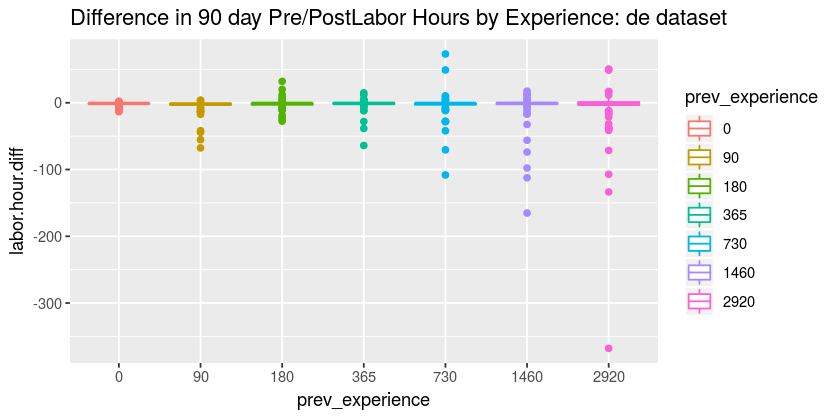

In [608]:
de.power.df <- subset.and.review.variables(de.power.df)

## Review Variables, Persian Wikipedia

[1] "========================"
[1] "Review Variables For: fa"
[1] "========================"

[1] "Total rows: 2844"

[1] "BLOCKING VARIABLES"
[1] "--------------------"
[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                     0.9009
2      90                     0.5000
3     180                     0.5000
4     365                     0.5000
5     730                     0.5000
6    1460                     0.5000
7    2920                     0.5000

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         2.043
2      90                         3.998
3     180                         2.890
4     365                         3.819
5     730                         7.127
6    1460                         9.300
7    2920                        15.844

[1] "Number of rows before removing inactive users: 2844"
[1] "Number of rows after removing inactive users: 1600"

[1] "pre

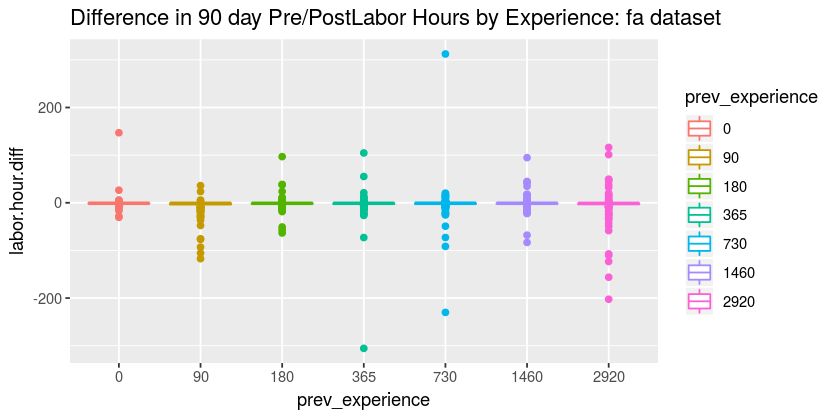

In [609]:
fa.power.df <- subset.and.review.variables(fa.power.df)

## Review Variables, Arabic Wikipedia

[1] "========================"
[1] "Review Variables For: ar"
[1] "========================"

[1] "Total rows: 2875"

[1] "BLOCKING VARIABLES"
[1] "--------------------"
[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                     0.8421
2      90                     0.5000
3     180                     0.5000
4     365                     0.5000
5     730                     0.5000
6    1460                     0.5000
7    2920                     0.5000

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         1.541
2      90                         5.155
3     180                         6.530
4     365                         3.922
5     730                         6.778
6    1460                        10.074
7    2920                        17.173

[1] "Number of rows before removing inactive users: 2875"
[1] "Number of rows after removing inactive users: 1600"

[1] "pre

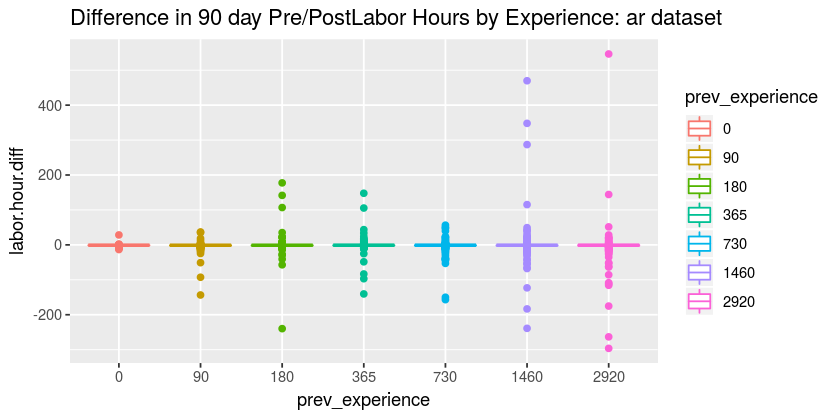

In [610]:
ar.power.df <- subset.and.review.variables(ar.power.df)

## Review Variables, Polish Wikipedia

[1] "========================"
[1] "Review Variables For: fa"
[1] "========================"

[1] "Total rows: 2844"

[1] "BLOCKING VARIABLES"
[1] "--------------------"
[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                     0.9009
2      90                     0.5000
3     180                     0.5000
4     365                     0.5000
5     730                     0.5000
6    1460                     0.5000
7    2920                     0.5000

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         2.043
2      90                         3.998
3     180                         2.890
4     365                         3.819
5     730                         7.127
6    1460                         9.300
7    2920                        15.844

[1] "Number of rows before removing inactive users: 2844"
[1] "Number of rows after removing inactive users: 1600"

[1] "pre

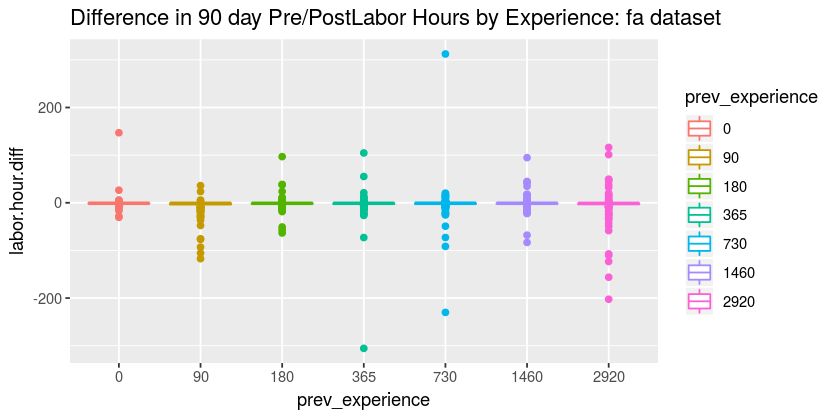

In [611]:
pl.power.df <- subset.and.review.variables(pl.power.df)

## Construct and Review an Account-Period Dataset for Survival Analysis

In [612]:
initialize_account.periods.df <- function(){
    account.periods.df <- data.frame(
        user_id                       = NA,
        user_registration             = NA,
        lang                          = NA,
        prev_experience               = NA,
        active_in_30_pre_treatment    = NA,
        num_prev_thanks_pre_treatment = NA,
        num_edits_90_pre_treatment    = NA,
        labour_hours_90_pre_treatment = NA,
        week                          = NA,
        num_edits                     = NA,
        any_edits                     = NA,
        labor_hours                   = NA,
        inactive                      = NA
    )
    account.periods.df
}

# Create a person period dataset from a single row of the power analysis data
#
#` @param row The row to convert into a series of rows
create.person.period.rows <- function(row){


    ## we use the definition that someone is active
    ## if they edited at least once in a one-month period
    ## this is why we rate active-ness as "was active in
    ## the four week period after the beginning of this week"
    last.person.period.week = 8

    num.edit.post.treat.keys = c()
    labor.hours.post.treat.keys = c()

    for(i in seq(1,12)){
        num.edit.post.treat.keys <- append(num.edit.post.treat.keys,
                                           paste("num_edits_week_",i,"_post_treatment", sep=""))
        labor.hours.post.treat.keys <- append(num.edit.post.treat.keys,
                                           paste("labor_hours_week_",i,"_post_treatment", sep=""))
    }

    account.periods.df <- initialize_account.periods.df()

    ## iterate backward from the 12th week
    ## and set still.active to true from the
    ## last week that we observe activity in the account
    still.active <- FALSE
    for(i in seq(12,1)){
        num.edit.key = num.edit.post.treat.keys[i]
        labor.hours.key = labor.hours.post.treat.keys[i]

        if(still.active == FALSE){
            if(row[[num.edit.key]] > 0){
                still.active = TRUE
            }
        }

        inactive <- NA
        if(i<=last.person.period.week){
            inactive <- still.active != TRUE
        }
        #print(paste("week: ", i,", inactive: ", inactive, ", still.active: ", still.active, sep=""))
        
        ## If the account is 

        row.df <- data.frame(
            user_id                       = row$user_id,
            user_registration             = as.Date(row$user_registration),
            lang                          = toString(row$lang),
            prev_experience               = as.integer(toString(row$prev_experience)),
            active_in_30_pre_treatment    = row$active_in_30_pre_treatment,
            num_prev_thanks_pre_treatment = row$num_prev_thanks_pre_treatment,
            num_edits_90_pre_treatment    = row$num_edits_90_pre_treatment,
            labour_hours_90_pre_treatment = row$labour_hours_90_pre_treatment,
            week                          = i,
            num_edits                     = row[[num.edit.key]],
            any_edits                     = row[[num.edit.key]] > 0,
            labor_hours                   = row[[labor.hours.key]],
            inactive                      = as.integer(inactive)
        )
        account.periods.df <- rbind(account.periods.df, row.df)
    }

    account.periods.df <- subset(account.periods.df, is.na(user_id)!=TRUE)
    account.periods.df
}

In [613]:
# Make a test row's edits and labor hours over N weeks blank
#
#` @row The row to make blank
create.blank.test.row <- function(row){
    for(i in seq(1,12)){
        row[paste("num_edits_week_",i,"_post_treatment", sep="")] <- 0
        row[paste("any_edits_week_",i,"_post_treatment", sep="")] <- FALSE
        row[paste("labor_hours_week_",i,"_post_treatment", sep="")] <- 0
        row[paste("any_labor_hours_week_",i,"_post_treatment", sep="")] <- FALSE

    }
    
    for(i in seq(1,12)){
    }
    row
}

#### Test Cases
* no edits at any time
* edits in the last week
* edits in the 7th week

In [614]:
## initialize test DF
test.account.df <- de.power.df[1,]
test.account.df <- create.blank.test.row(test.account.df[1,])

## CASE: NO EDITS AT ANY TIME
test.ap.df <- create.person.period.rows(test.account.df)

# expect: 0 weeks active
print(paste(nrow(subset(test.ap.df, inactive==0)), "weeks active")) 

## CASE: 1 EDIT IN 12th WEEK
test.account.df['num_edits_week_12_post_treatment']  = 1
test.account.df['labor_hours_week_12_post_treatment']  = 1
test.ap.df <- create.person.period.rows(test.account.df)
# expect: 8 weeks active
print(paste(nrow(subset(test.ap.df, inactive==0)), "weeks active")) 

## CASE: 1 EDIT IN 9th WEEK
test.account.df <- create.blank.test.row(test.account.df[1,])
test.account.df['num_edits_week_9_post_treatment']  = 1
test.account.df['labor_hours_week_9_post_treatment']  = 1
test.ap.df <- create.person.period.rows(test.account.df)
# expect: 8 weeks active
print(paste(nrow(subset(test.ap.df, inactive==0)), "weeks active")) 


## CASE: 1 EDIT IN 8th WEEK
test.account.df <- create.blank.test.row(test.account.df[1,])
test.account.df['num_edits_week_8_post_treatment']  = 1
test.account.df['labor_hours_week_8_post_treatment']  = 1
test.ap.df <- create.person.period.rows(test.account.df)
# expect: 8 weeks active
print(paste(nrow(subset(test.ap.df, inactive==0)), "weeks active")) 

## CASE: 1 EDIT IN 6th WEEK
test.account.df <- create.blank.test.row(test.account.df[1,])
test.account.df['num_edits_week_6_post_treatment']  = 1
test.account.df['labor_hours_week_6_post_treatment']  = 1
test.ap.df <- create.person.period.rows(test.account.df)
# expect: 6 weeks active
print(paste(nrow(subset(test.ap.df, inactive==0)), "weeks active")) 

[1] "0 weeks active"
[1] "8 weeks active"
[1] "8 weeks active"
[1] "8 weeks active"
[1] "6 weeks active"


### Generate an Account Period Dataframe

In [620]:
# generate.account.period.dataframe
# Create an account period dataframe from a power analysis dataframe
# ` 
# `@power.df power analysis dataframe
generate.account.period.dataframe <- function(power.df){
    print(paste("Generating account period dataframe for", unique(power.df$lang)))
    account.periods.df <- initialize_account.periods.df()
    for(i in seq(1,nrow(power.df))){
        if(i %% 100 == 0){
            cat(".")
            flush.console()
        }
        row = power.df[i,]
        account.period.df  <- create.person.period.rows(row)
        account.periods.df <- rbind(account.periods.df, account.period.df)
    }
    cat("\n")
    account.periods.df <- subset(account.periods.df, is.na(user_id)!=TRUE)
    print(paste("Number of participants: ", nrow(power.df), sep=""))
    print(paste("Number of account periods: ", nrow(account.periods.df), sep="")) 
    print(paste("Number periods per account: ", nrow(account.periods.df) / nrow(power.df)), sep="")
    account.periods.df
}

### Generate German Account Period Dataframe

In [621]:
de.account.periods.df <- generate.account.period.dataframe(de.power.df)

[1] "Generating account period dataframe for de"
.........
[1] "Number of participants: 900"
[1] "Number of account periods: 10800"
[1] "Number periods per account:  12"


### Generate Persian Account Period Dataframe

In [622]:
fa.account.periods.df <- generate.account.period.dataframe(fa.power.df)

[1] "Generating account period dataframe for fa"
................
[1] "Number of participants: 1600"
[1] "Number of account periods: 19200"
[1] "Number periods per account:  12"


### Generate Arabic Account Period Dataframe

In [623]:
ar.account.periods.df <- generate.account.period.dataframe(ar.power.df)

[1] "Generating account period dataframe for ar"
................
[1] "Number of participants: 1600"
[1] "Number of account periods: 19200"
[1] "Number periods per account:  12"


### Generate Polish Account Period Dataframe

In [624]:
pl.account.periods.df <- generate.account.period.dataframe(pl.power.df)

[1] "Generating account period dataframe for fa"
................
[1] "Number of participants: 1600"
[1] "Number of account periods: 19200"
[1] "Number periods per account:  12"


## Generate Survival Analysis

In [662]:
generate.survival.analysis <- function(account.periods.df){
    print(paste("Survival Analysis for", unique(account.periods.df$lang)))
    print(paste("------------------------"))
    cat("\n")

    print(paste("Information for Deciding on Prev Active Cutoff:", unique(account.periods.df$lang)))
    print(paste("Active 90 days prev % inactive by week eight:", 
            prettyNum(mean(subset(account.periods.df, week==8)$inactive)*100)))
    print(paste("Active 30 days prev % inactive by week eight:", 
                prettyNum(mean(subset(account.periods.df, active_in_30_pre_treatment=="True" & week==8)$inactive)*100)))
    print(paste("Active 90 days but Inactive 30 days prev % inactive by week eight:", 
        prettyNum(mean(subset(account.periods.df, active_in_30_pre_treatment=="False" & week==8)$inactive)*100)))
    cat("\n")

    ## define newcomer as an account that has 0 previous experience
    ## (note: in the full study, we're going to drop anyone with fewer than 3 edits)
    account.periods.df$newcomer <- account.periods.df$prev_experience== 0
    
#     print("Base Survival Model Results")
#     account.survival.fit <- survfit(Surv(week, inactive) ~ 1, data=account.periods.df)
#     ## we expect weeks over 8 to be removed for NAs
#     print(summary(account.survival.fit))
#     cat("\n")
    
    print("Base Logistic Regression Results")
    print(summary(glm(inactive ~ week, 
                      data = account.periods.df, 
                      family=binomial)))
    cat("\n")

#     print("Newcomer Survival Model Results")
#     account.periods.df$newcomer <- account.periods.df$prev_experience== 0 
#     account.survival.fit <- survfit(Surv(week, inactive) ~ newcomer, data=account.periods.df)
#     ## we expect weeks over 8 to be removed for NAs
#     print(summary(account.survival.fit))
#     cat("\n")
    
    
    print("Newcomer Logistic Regression Results")
    print(summary(glm(inactive ~ week + newcomer, 
                      data = account.periods.df, 
                      family=binomial)))
    cat("\n")

}

### Survival Analysis for German

In [663]:
generate.survival.analysis(de.account.periods.df)

[1] "Survival Analysis for de"
[1] "------------------------"

[1] "Information for Deciding on Prev Active Cutoff: de"
[1] "Active 90 days prev % inactive by week eight: 80.22"
[1] "Active 30 days prev % inactive by week eight: 68.86"
[1] "Active 90 days but Inactive 30 days prev % inactive by week eight: 89.78"

[1] "Base Logistic Regression Results"

Call:
glm(formula = inactive ~ week, family = binomial, data = account.periods.df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.794  -1.493   0.727   0.823   0.891  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.6222     0.0572   10.87  < 2e-16 ***
week          0.0956     0.0118    8.07  7.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8266.6  on 7199  degrees of freedom
Residual deviance: 8200.8  on 7198  degrees of freedom
  (3600 observations deleted due to missingness

### Survival Analysis for Persian

In [664]:
generate.survival.analysis(fa.account.periods.df)

[1] "Survival Analysis for fa"
[1] "------------------------"

[1] "Information for Deciding on Prev Active Cutoff: fa"
[1] "Active 90 days prev % inactive by week eight: 83.75"
[1] "Active 30 days prev % inactive by week eight: 72.74"
[1] "Active 90 days but Inactive 30 days prev % inactive by week eight: 92.25"

[1] "Base Logistic Regression Results"

Call:
glm(formula = inactive ~ week, family = binomial, data = account.periods.df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.878   0.613   0.671   0.764   0.832  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.7836     0.0446    17.6   <2e-16 ***
week          0.0989     0.0093    10.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13769  on 12799  degrees of freedom
Residual deviance: 13654  on 12798  degrees of freedom
  (6400 observations deleted due to missingness

### Survival Analysis for Arabic

In [665]:
generate.survival.analysis(ar.account.periods.df)

[1] "Survival Analysis for ar"
[1] "------------------------"

[1] "Information for Deciding on Prev Active Cutoff: ar"
[1] "Active 90 days prev % inactive by week eight: 83.56"
[1] "Active 30 days prev % inactive by week eight: 73.7"
[1] "Active 90 days but Inactive 30 days prev % inactive by week eight: 90.72"

[1] "Base Logistic Regression Results"

Call:
glm(formula = inactive ~ week, family = binomial, data = account.periods.df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.887   0.608   0.655   0.730   0.784  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.93988    0.04576   20.54   <2e-16 ***
week         0.08187    0.00948    8.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13307  on 12799  degrees of freedom
Residual deviance: 13232  on 12798  degrees of freedom
  (6400 observations deleted due to missingness)

### Survival Analysis for Polish

In [666]:
generate.survival.analysis(pl.account.periods.df)

[1] "Survival Analysis for fa"
[1] "------------------------"

[1] "Information for Deciding on Prev Active Cutoff: fa"
[1] "Active 90 days prev % inactive by week eight: 83.75"
[1] "Active 30 days prev % inactive by week eight: 72.74"
[1] "Active 90 days but Inactive 30 days prev % inactive by week eight: 92.25"

[1] "Base Logistic Regression Results"

Call:
glm(formula = inactive ~ week, family = binomial, data = account.periods.df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.878   0.613   0.671   0.764   0.832  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.7836     0.0446    17.6   <2e-16 ***
week          0.0989     0.0093    10.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13769  on 12799  degrees of freedom
Residual deviance: 13654  on 12798  degrees of freedom
  (6400 observations deleted due to missingness